In [1]:
import rasterio as rio
from rasterio.plot import plotting_extent
import rasterio.plot
import numpy as np
from topolib.subsetDat import subsetBBox;
from topolib import gda_lib;
from pyproj import Proj, transform
from icepyx import icesat2data as ipd
%matplotlib inline
import matplotlib.pyplot as plt 
import sys
import glob
import pdal
import getpass

In [2]:
indir = '/home/jovyan/shared/data-aragon/ATL03_CA/'
outdir = '/home/jovyan/shared/data-aragon/ATL03_CA/tif/'

In [3]:
#get .laz files
lazfiles = glob.glob(indir+'*laz')
lazfiles

['/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt2l_xyz_conf.laz',
 '/home/jovyan/shared/data-aragon/ATL03_CA/ATL03_CA_TE_gtlr.laz',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt2r_xyz_conf.laz',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt3l_xyz_conf.laz',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt1r_xyz_conf.laz',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt1l_xyz_conf.laz',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf.laz']

In [4]:
#get .h5 files 
h5files = glob.glob(indir+'*h5')
h5files

['/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt2r_xyz_conf.h5',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt2l_xyz_conf.h5',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt3r_xyz_conf.h5',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt1l_xyz_conf.h5',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt1r_xyz_conf.h5',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01.h5',
 '/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt3l_xyz_conf.h5']

# Visualize the dem .tif 

In [5]:
raster_path = '/home/jovyan/shared/data-aragon/ASO_3M_PCDTM_USCATE_20191010_20191010.tif'
ds = rio.open(raster_path)
ASOdem = ds.read(1)
ASOdem = np.ma.masked_equal(ASOdem,gda_lib.get_ndv(ds))
xmin,ymin,xmax,ymax = ds.bounds
ds.crs

CRS.from_epsg(32611)

In [ ]:
[xmin,ymin,xmax,ymax] = subsetBBox(raster_path,ds.crs,'epsg:7912')
xmin,ymin,xmax,ymax

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
im = rio.plot.show(ASOdem, ax=ax,cmap='gist_earth',extent=[xmin,xmax,ymin,ymax])

# Edit laz_to_tif.json to change pdal function

In [ ]:
! pdal info /home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt1r_xyz_conf.laz -p 2000

In [ ]:
! pdal info /home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt1r_xyz_conf.laz --summary

In [ ]:
'bounds':'(['+str(xmin)+','+str(xmax)+'],['+str(ymin)+','+str(ymax)+'])'
data['pipeline'].append({
    'type':"filters.range",
    'limits':"UserData[0:4]"
})
'radius':1000

In [17]:
import json

bounds = '(['+str(xmin)+','+str(xmax)+'],['+str(ymin)+','+str(ymax)+'])'

data = {}
data['pipeline'] = []
data['pipeline'].append({
    'type':"readers.las",
    'override_srs':"EPSG:7912"
})
data['pipeline'].append({
    'type':"filters.reprojection",
    'in_srs':"EPSG:7912",
    'out_srs':"EPSG:32611"
})
data['pipeline'].append({
    'type':"filters.range",
    'limits':"UserData[0:4]"
})
data['pipeline'].append({
    'type':"writers.gdal",
    'gdaldriver':"GTiff",
    'gdalopts':"TILED=YES,COMPRESS=LZW,BIGTIFF=YES,NUM_THREADS=ALL_CPUS,SPARSE_OK=TRUE",
    'data_type':"float32",
    'resolution':100,
    'radius':1000
})

with open('laz_to_tiff2.json', 'w') as outfile:
    json.dump(data, outfile)

# Use PDAL pipeline to convert from [LAZ to GeoTiff](https://github.com/ICESAT-2HackWeek/SeasonalSnow/tree/master/contributors/jomey)


In [18]:
! pdal pipeline ~/SeasonalSnow/contributors/Nina/laz_to_tiff2.json --readers.las.filename=/home/jovyan/shared/data-aragon/ATL03_CA/processed_ATL03_20191008182255_01810506_003_01_gt1r_xyz_conf.laz --writers.gdal.filename=/home/jovyan/shared/data-aragon/ATL03_CA/tif/processed_ATL03_20191008182255_01810506_003_01_gt1r_xyz_conf.tif

# Visualize the pdal .tif 
In not otherwise specified, there are 6 bands in the output .tif - in the following order:

“min”, “max”, “mean”, “idw”, “count”, “stdev” and “all”

In [ ]:
!ls $outdir/

In [ ]:
!gdalinfo $outdir/processed_ATL03_20191008182255_01810506_003_01_gt1r_xyz_conf.tif -stats

In [19]:
ds_pdal = rio.open(outdir+'processed_ATL03_20191008182255_01810506_003_01_gt1r_xyz_conf.tif')
dem = ds_pdal.read(3)
dem = np.ma.masked_equal(dem,-9999)
xmin2,ymin2,xmax2,ymax2 = ds.bounds
ds.crs

CRS.from_epsg(32611)

In [ ]:
dem

In [ ]:
np.shape(dem)

In [ ]:
dem.count()

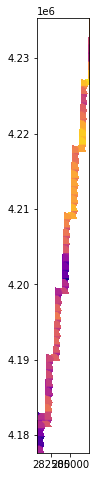

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
#im = rio.plot.show(ASOdem, ax=ax,cmap='gist_earth')
i = rio.plot.show(dem, ax=ax,cmap='plasma',extent=[xmin2,xmax2,ymin2,ymax2])
#ax.axis((xmin+100, xmax+100, ymin+100, ymax+100))
#ax.colorbar(dem,label='Elevation [m]')

(242815.0, 307684.0, 4178989.0, 4234948.0)

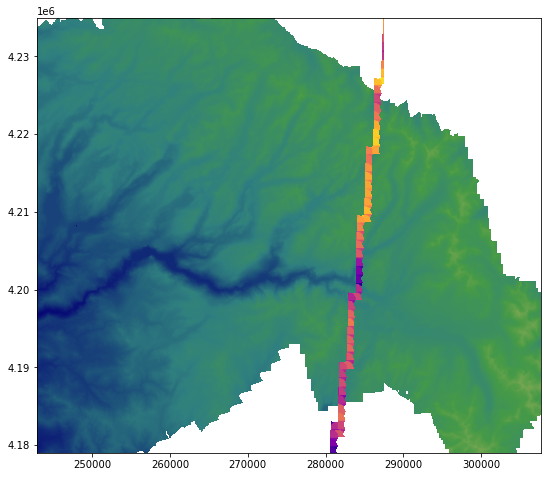

In [7]:
fig,ax = plt.subplots(figsize=(10,8))
im = rio.plot.show(ASOdem, ax=ax,cmap='gist_earth',extent=[xmin,xmax,ymin,ymax])
i = rio.plot.show(dem, ax=ax,cmap='plasma',extent=[xmin2,xmax2,ymin2,ymax2])
ax.axis((xmin+100, xmax+100, ymin+100, ymax+100))

In [ ]:
ds.meta

# Get ATL06 data to compare with 

In [20]:
# depedencies
import getpass
from topolib.subsetDat import subsetBBox;
from topolib import IceSat2Data;
import glob
import rasterio
from topolib import gda_lib;
from topolib import dwnldArctic
import numpy as np
import geopandas as gpd
from multiprocessing import Pool

In [21]:
# inputs
datafolderOut = '/home/jovyan/shared/data-aragon/ATL06_CA/'

# Specify the variables of interest
LIce_var = ['atl06_quality_summary','delta_time','h_li','hli_sigma',\
           'latitude','longitude','segment_id','sigma_geo_h']
variables = {
    'beams': [
        '/land_ice_segments/'+LIce_var[0],
        '/land_ice_segments/'+LIce_var[1],
        '/land_ice_segments/'+LIce_var[2],
        '/land_ice_segments/'+LIce_var[3],
        '/land_ice_segments/'+LIce_var[4],
        '/land_ice_segments/'+LIce_var[5],
        '/land_ice_segments/'+LIce_var[6],
        '/land_ice_segments/'+LIce_var[7],
        '/ancillary_data/atlas_sdp_gps_epoch',
    ],
    'other': [
        '/orbit_info/cycle_number',
        '/orbit_info/rgt',
        '/orbit_info/orbit_number',
    ]
}

# Custom time range of interest
# define full_per = 1
full_per = 1
time_range = {
        'start_date': '2019-10-07',
        'end_date': '2019-10-11'
}

# Enter your Earthdata Login user name
user_id = 'nina.aragon7'
# Enter your email address associated with your Earthdata Login account
email = 'aragonch@oregonstate.edu'

In [10]:
# preprocessing
[L,B,R,T] = subsetBBox(raster_path,ds.crs,'epsg:4326') # now read projection from DEM, convert to WGS84
# Area of interest
boundaries = {
    'LowerLeft_Lon': L,
    'LowerLeft_Lat': B,
    'UpperRight_Lon': R,
    'UpperRight_Lat': T,
}
L,B,R,T

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.

(-119.91910216526328,
 37.721153213268956,
 -119.19868268078534,
 38.24106453792272)

In [ ]:
# Earthdata Login credentials
password = getpass.getpass('Earthdata Login password: ')

# Setup a search session
search = IceSat2Data(user_id, password, variables=variables)

In [ ]:
# Search for granules in bounding box without download through all datasets
search.search_granules(bounding_box=boundaries)

# Search for granules in bounding box without download for specific time range
search.search_granules(bounding_box=boundaries, time_range=time_range)

In [ ]:
# NOTE: file paths have to be explicitly defined 
# BEFORE submitting 

params = {}
if full_per:
    params['time_range'] = time_range

# Submit a download order to NSIDC with no time restriction
search.order_data(
    email,
    datafolderOut,
    boundaries,
    **params
)

In [22]:
# glob to list of files
ATL06_list = glob.glob(datafolderOut+'*.h5')
ATL06_list

['/home/jovyan/shared/data-aragon/ATL06_CA/processed_ATL06_20191008182255_01810506_003_01.h5']

In [23]:
# read hdf5 into a geodataframe
dataset_dict={'land_ice_segments':LIce_var, 'land_ice_segments/ground_track':['x_atc']}

In [24]:
## add recursively
ATL06_gdf_list = [gda_lib.ATL06_2_gdf(x,dataset_dict) for x in ATL06_list]
ATL06_gdf_list = [x.to_crs(ds.crs) for x in ATL06_gdf_list]
ATL06_gdf_list;
big_gdf = gda_lib.concat_gdf(ATL06_gdf_list)

/home/jovyan/topohack/topolib/gda_lib.py:33: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(filename) as h5f:
/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
big_gdf

,atl06_quality_summary,delta_time,h_li,latitude,longitude,segment_id,sigma_geo_h,pair,beam,p_b,geometry
0,1,5.579451e+07,2745.797607,38.073983,-119.444229,790610.0,12.533924,1.0,0.0,1.0_0.0,POINT (285603.275 4216844.702)
1,1,5.579451e+07,2743.435547,38.073803,-119.444251,790611.0,12.067012,1.0,0.0,1.0_0.0,POINT (285600.792 4216824.810)
2,1,5.579451e+07,2737.395020,38.073624,-119.444274,790612.0,11.913810,1.0,0.0,1.0_0.0,POINT (285598.244 4216804.925)
3,0,5.579451e+07,2734.422607,38.073444,-119.444297,790613.0,10.783306,1.0,0.0,1.0_0.0,POINT (285595.738 4216785.035)
4,0,5.579451e+07,2731.613770,38.073264,-119.444319,790614.0,10.104366,1.0,0.0,1.0_0.0,POINT (285593.239 4216765.145)
...,...,...,...,...,...,...,...,...,...,...,...
1821,1,5.579452e+07,1538.856323,37.722195,-119.561512,792598.0,28.285862,3.0,1.0,3.0_1.0,POINT (274241.268 4178081.520)
1822,1,5.579452e+07,NaN,37.722015,-119.561527,792599.0,20.471485,3.0,1.0,3.0_1.0,POINT (274239.415 4178061.550)
1823,1,5.579452e+07,NaN,37.721834,-119.561537,792600.0,20.099787,3.0,1.0,3.0_1.0,POINT (274237.963 4178041.533)
1824,1,5.579452e+07,NaN,37.721654,-119.561546,792601.0,20.148592,3.0,1.0,3.0_1.0,POINT (274236.614 4178021.501)


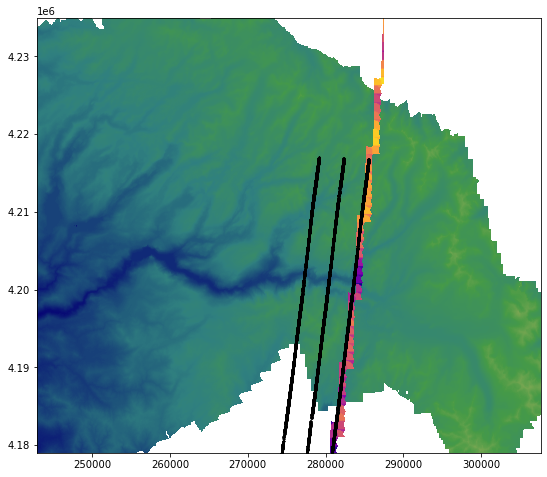

In [13]:
fig,ax = plt.subplots(figsize=(10,8))
im = rio.plot.show(ASOdem, ax=ax,cmap='gist_earth',extent=[xmin,xmax,ymin,ymax])
i = rio.plot.show(dem, ax=ax,cmap='plasma',extent=[xmin2,xmax2,ymin2,ymax2])
ax.axis((xmin+100, xmax+100, ymin+100, ymax+100))
for gdf in ATL06_gdf_list:
    gdf.plot(ax=ax,marker='*', color='black',markersize=1)

In [25]:
# separate flight tracks for line-by-line comparison
df1,df2,df3,df4,df5,df6 = [x for x_,x in ATL06_gdf_list[0].groupby(ATL06_gdf_list[0]['p_b'])] #pick 1 ATL06 and seperate it into 6
df_list = [df1,df2,df3,df4,df5,df6]

In [27]:
# Only looking at one beam
df_list = [df1]

0.3559318365052689 2.0928635119830377 0.02686770592569911


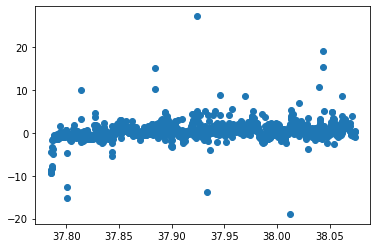

In [28]:
# comparison of ground data and ATL06 using a 20m buffer sampler
# colors represent the flight lines shown above
df_test_big = gda_lib.buffer_sampler(ds,big_gdf,20,ret_gdf=True)
df_test_big['snow_on_off'] = df_test_big['h_li']-df_test_big['med']

fig,ax = plt.subplots()
for gdf in df_list:
    df_test = gda_lib.buffer_sampler(ds,gdf,20,ret_gdf=True)
    df_test['snow_on_off'] = df_test['h_li']-df_test['med']
    ax.scatter(df_test['latitude'],df_test['snow_on_off'])
    print(df_test['snow_on_off'].mean(),df_test['snow_on_off'].std(),100*df_test['snow_on_off'].mean()/(df_test['h_li'].max()-df_test['h_li'].min()))
# df_test['snow_on_off'].hist(bins=30)
# ax.scatter(df_test['latitude'],df_test['snow_on_off'])

big_gdf['diff'] = df_test_big['snow_on_off']

In [21]:
df_test_big.head()

,geometry,atl06_quality_summary,beam,delta_time,h_li,latitude,longitude,p_b,pair,segment_id,sigma_geo_h,med,snow_on_off
0,"POLYGON ((285623.275 4216844.702, 285623.178 4...",1,0.0,5.579451e+07,2745.797607,38.073983,-119.444229,1.0_0.0,1.0,790610.0,12.533924,2745.336060,0.461548
1,"POLYGON ((285620.792 4216824.810, 285620.696 4...",1,0.0,5.579451e+07,2743.435547,38.073803,-119.444251,1.0_0.0,1.0,790611.0,12.067012,2743.251953,0.183594
2,"POLYGON ((285618.244 4216804.925, 285618.148 4...",1,0.0,5.579451e+07,2737.395020,38.073624,-119.444274,1.0_0.0,1.0,790612.0,11.913810,2738.328003,-0.932983
3,"POLYGON ((285615.738 4216785.035, 285615.641 4...",0,0.0,5.579451e+07,2734.422607,38.073444,-119.444297,1.0_0.0,1.0,790613.0,10.783306,2734.448486,-0.025879
4,"POLYGON ((285613.239 4216765.145, 285613.143 4...",0,0.0,5.579451e+07,2731.613770,38.073264,-119.444319,1.0_0.0,1.0,790614.0,10.104366,2731.385010,0.228760


675.5604681629952 146.73092704860164 50.99504492726737


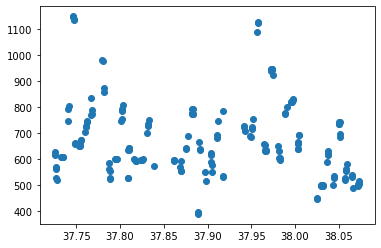

In [29]:
# comparison of ground data and ATL06 using a 20m buffer sampler
# colors represent the flight lines shown above
df_test_big = gda_lib.buffer_sampler(ds_pdal,big_gdf,20,ret_gdf=True)
df_test_big['snow_on_off'] = df_test_big['h_li']-df_test_big['med']

fig,ax = plt.subplots()
for gdf in df_list:
    df_test = gda_lib.buffer_sampler(ds_pdal,gdf,20,ret_gdf=True)
    df_test['snow_on_off'] = df_test['h_li']-df_test['med']
    ax.scatter(df_test['latitude'],df_test['snow_on_off'])
    print(df_test['snow_on_off'].mean(),df_test['snow_on_off'].std(),100*df_test['snow_on_off'].mean()/(df_test['h_li'].max()-df_test['h_li'].min()))
# df_test['snow_on_off'].hist(bins=30)
# ax.scatter(df_test['latitude'],df_test['snow_on_off'])

big_gdf['diff'] = df_test_big['snow_on_off']

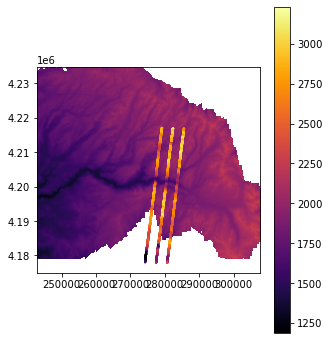

In [30]:
# point-by-point comparison
fig,ax = plt.subplots(figsize=(5,6))
im = ax.imshow(ASOdem,cmap='inferno',extent=[xmin2,xmax2,ymin2,ymax2])
big_gdf.plot('h_li',legend=True,ax=ax,cmap='inferno',s=1)

In [31]:
# sample data along same ground tracks
df_test_big_slp = gda_lib.buffer_sampler(ds2,big_gdf,20,ret_gdf=True)
good_idx = df_test_big['atl06_quality_summary']==0
df_test_big = df_test_big.loc[good_idx]

df_test_big_asp = gda_lib.buffer_sampler(ds3,big_gdf,20,ret_gdf=True)

NameError: name 'ds2' is not defined

In [ ]:
df_test_big_slp = df_test_big_slp.loc[good_idx]
fig,ax = plt.subplots()
ax.scatter(df_test_big_slp['med'],df_test_big['snow_on_off'],\
          c=abs(df_test_big['snow_on_off']),vmin=-7,vmax=7)
plt.ylim(-25,25)
plt.ylabel('Error [m]')
plt.xlabel('Slope [deg]')

In [ ]:
# cloud compare to look at point clouds together 

# Holoviews

In [ ]:
gt1l = xr.open_dataset(filePath, group=group, engine='h5netcdf')

In [ ]:
with h5py.File(atl03_fn,'r') as fi:
    f[X] = X
    